<div style="font-size:20pt"> This notebook implement a normal vector-based propagation algorithm to detecting edge of 3D mesh objects <div>
<div style="margin-top: 15px; font-size:20pt"> Overall pipeline:</div>
<div style="margin-top: 15px"><img src="pipelines/Normal vector-based propagation.png" width=1200></div>

<div style="font-size:27pt">Table of Contents</div>

## Import Libraries and Mesh

In [24]:
import os
import pyvista as pv
import time
import numpy as np
from collections import defaultdict, deque
import copy
import gc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [25]:
time_start = time.time()

In [26]:
mesh = pv.read('../CG_dataset/brick_part01.obj') 

2025-07-11 10:16:27.796 ( 282.007s) [    7FD44EC372C0]       vtkOBJReader.cxx:216   WARN| vtkOBJReader (0x4aa776f0): unexpected data at end of line in OBJ file L.5
2025-07-11 10:16:27.796 ( 282.007s) [    7FD44EC372C0]       vtkOBJReader.cxx:216   WARN| vtkOBJReader (0x4aa776f0): unexpected data at end of line in OBJ file L.7
2025-07-11 10:16:27.796 ( 282.007s) [    7FD44EC372C0]       vtkOBJReader.cxx:216   WARN| vtkOBJReader (0x4aa776f0): unexpected data at end of line in OBJ file L.9
2025-07-11 10:16:27.796 ( 282.007s) [    7FD44EC372C0]       vtkOBJReader.cxx:216   WARN| vtkOBJReader (0x4aa776f0): unexpected data at end of line in OBJ file L.11
2025-07-11 10:16:27.796 ( 282.007s) [    7FD44EC372C0]       vtkOBJReader.cxx:216   WARN| vtkOBJReader (0x4aa776f0): unexpected data at end of line in OBJ file L.13
2025-07-11 10:16:27.796 ( 282.007s) [    7FD44EC372C0]       vtkOBJReader.cxx:216   WARN| vtkOBJReader (0x4aa776f0): unexpected data at end of line in OBJ file L.15
2025-07-11 10

## Laplacian Smoothing

In [27]:
def build_vertex_adjacency(faces: np.ndarray) -> dict[int, set[int]]:
    """
    Get adjacency of all vertices in the mesh.

    Parameters:
        faces (np.ndarray): An (N, 3) array where each row contains three vertex indices representing a triangle.

    Returns:
        dict[int, set[int]]: Dictionary mapping each vertex to a set of its adjacent vertices.
    """
    adjacency: dict[int, set[int]] = defaultdict(set)

    for i, j, k in faces:
        adjacency[i].update((j, k))
        adjacency[j].update((i, k))
        adjacency[k].update((i, j))

    return adjacency

def laplacian_smoothing(mesh: pv.PolyData, iterations):
    
    # Extract face indices (reshape from PyVista's format)
    faces = mesh.faces.reshape((-1, 4))[:, 1:]  # Drop the leading "3" of each triangle
    adjacency = build_vertex_adjacency(faces)

    points = mesh.points.copy()

    for _ in range(iterations):
        new_points = points.copy()
        for i in range(len(points)):
            neighbors = list(adjacency[i])
            if not neighbors:
                continue
            neighbor_coords = points[neighbors]
            new_points[i] = neighbor_coords.mean(axis=0)
        points = new_points  # update for next iteration

    # Create a new smoothed mesh to avoid altering the original
    smoothed_mesh = pv.PolyData(points, mesh.faces)
    return smoothed_mesh


In [28]:
smoothed_mesh = laplacian_smoothing(mesh, iterations=3)

In [29]:
vertices = smoothed_mesh.points 
faces_1D = smoothed_mesh.faces
faces_nD = smoothed_mesh.faces.reshape((-1, 4))[:, 1:]

del faces_1D
gc.collect()

29

## Surface Segmentation 

In [30]:
def build_face_adjacency(faces):
    """
    Build face adjacency dictionary. Two faces are adjacent if they share exactly two vertices (i.e., share an edge).

    Parameters:
        faces (np.ndarray): An (M, 3) array of triangle vertex indices.

    Returns:
        dict[int, set[int]]: Mapping from face index to set of neighboring face indices.
    """
    edge_to_faces = defaultdict(set)

    # Step 1: Map each edge to the faces that contain it
    for face_idx, (i, j, k) in enumerate(faces):
        edges = [
            tuple(sorted((i, j))),
            tuple(sorted((j, k))),
            tuple(sorted((k, i)))
        ]
        for edge in edges:
            edge_to_faces[edge].add(face_idx)

    # Step 2: Build face adjacency based on shared edges
    face_adjacency = defaultdict(set)
    for edge, face_indices in edge_to_faces.items():
        if len(face_indices) < 2:
            continue  # not a shared edge
        face_indices = list(face_indices)
        for i in range(len(face_indices)):
            for j in range(i + 1, len(face_indices)):
                fi, fj = face_indices[i], face_indices[j]
                face_adjacency[fi].add(fj)
                face_adjacency[fj].add(fi)

    return dict(face_adjacency)


def convert_to_builtin_int(obj):
    if isinstance(obj, dict):
        return {convert_to_builtin_int(k): convert_to_builtin_int(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_builtin_int(i) for i in obj]
    elif isinstance(obj, set):
        return {convert_to_builtin_int(i) for i in obj}
    elif isinstance(obj, tuple):
        return tuple(convert_to_builtin_int(i) for i in obj)
    elif isinstance(obj, np.integer):  # Catch np.int64, np.int32, ...
        return int(obj)
    else:
        return obj
    

def compute_face_normals_and_areas(mesh):
    """
    Computes normal and area for each triangle face in the mesh.

    Returns:
        normals (np.ndarray): An (F, 3) array of unit normal vectors for each face.
        areas (np.ndarray): A (F,) array of areas for each face.

    Method:
        - Extract vertex indices for each triangle face.
        - Compute two edge vectors of the triangle.
        - Use cross product to get the face normal (not normalized).
        - Normalize to get unit normals.
        - Compute triangle area as half of the magnitude of the cross product.
    """
    faces = mesh.faces.reshape((-1, 4))[:, 1:]
    v0 = mesh.points[faces[:, 0]]
    v1 = mesh.points[faces[:, 1]]
    v2 = mesh.points[faces[:, 2]]
    
    cross = np.cross(v1 - v0, v2 - v0)
    areas = 0.5 * np.linalg.norm(cross, axis=1)
    normals = cross / np.maximum(np.linalg.norm(cross, axis=1, keepdims=True), 1e-8)
    return normals, areas


def normal_vector_angle(n_p, n_q, degrees=False):
    """
    Parameters:
    - n_p, n_q: 3D vectors (can be non-normalized).
    - degrees: If True, return angle in degrees. Otherwise, radians.

    Returns:
    - Angle between vectors
    """
    dot_product = np.dot(n_p, n_q)
    norm_p = np.linalg.norm(n_p)
    norm_q = np.linalg.norm(n_q)

    if norm_p == 0 or norm_q == 0:
        return 0.0

    cos_theta = np.clip(dot_product / (norm_p * norm_q), -1.0, 1.0)
    angle_rad = np.arccos(cos_theta)
    return np.degrees(angle_rad) if degrees else angle_rad


def sort_faces_by_flatness(face_normals, face_adjacency):
    """
    Compute 'flatness' of each face by averaging the angle to its neighboring face normals,
    then return a list of (face_index, flatness_value) sorted by flatness (ascending).

    Parameters:
        face_normals (np.ndarray): (M, 3) array of face normal vectors.
        face_adjacency (dict[int, set[int]]): adjacency list of faces.

    Returns:
        List[Tuple[int, float]]: list of (face_index, flatness), sorted by flatness.
    """
    flat_faces = []
    for fi, neighbors in face_adjacency.items():
        if not neighbors:
            continue
        angles = [normal_vector_angle(face_normals[fi], face_normals[nj]) for nj in neighbors]
        flatness = sum(angles) / len(angles)
        flat_faces.append((fi, flatness))

    flat_faces.sort(key=lambda x: x[1])  # ascending: flatter faces first
    return flat_faces


def cluster_surface_face_based(face_adjacency, face_normals, flat_f_sorted, weight=0.5, threshold=10.0):
    """
    Cluster faces on a mesh based on surface flatness and adjacency.

    Parameters:
        face_adjacency (dict[int, set[int]]): adjacency list of face indices.
        face_normals (np.ndarray): (M, 3) array of face normal vectors.
        flat_f_sorted (List[Tuple[int, float]]): list of (face_index, flatness), sorted by flatness ascending.
        weight (float): weight for combining local and cluster normal angle.
        threshold (float): max combined angle (in degrees) to include in the cluster.

    Returns:
        List[Set[int]]: list of clusters (each a set of face indices).
    """
    flat_f_sorted_copy = deque(flat_f_sorted)
    unvisited = set(range(len(face_normals)))
    clusters = []

    def compute_avg_angle(normal, neighbors):
        return np.mean([
            normal_vector_angle(normal, face_normals[nj])
            for nj in neighbors
        ])

    while unvisited:
        while flat_f_sorted_copy:
            start, _ = flat_f_sorted_copy.popleft()
            if start in unvisited:
                break
        else:
            break  # No unvisited faces left

        cluster = set([start])
        queue = deque([start])
        unvisited.remove(start)

        # Running sum of normals for this cluster
        normals_sum = face_normals[start].copy()

        while queue:
            fi = queue.popleft()
            for fj in face_adjacency.get(fi, []):
                if fj not in unvisited:
                    continue

                # Average angle of neighbor fj
                avg_angle_local = compute_avg_angle(face_normals[fi], face_adjacency.get(fj, []))

                # Cluster average normal
                cluster_normal = normals_sum / np.maximum(np.linalg.norm(normals_sum), 1e-8)
                avg_angle_cluster = compute_avg_angle(cluster_normal, face_adjacency.get(fj, []))

                # Weighted proximity
                proximity = weight * avg_angle_local + (1 - weight) * avg_angle_cluster

                if proximity < threshold:
                    cluster.add(fj)
                    queue.append(fj)
                    unvisited.remove(fj)
                    normals_sum += face_normals[fj]

        clusters.append(cluster)

    return clusters

In [31]:
f_adj = build_face_adjacency(faces_nD)
f_adj = convert_to_builtin_int(f_adj)

f_normals, areas = compute_face_normals_and_areas(smoothed_mesh)

flat_f_sorted = sort_faces_by_flatness(f_normals, f_adj)

In [32]:
clusters = cluster_surface_face_based(f_adj, f_normals, flat_f_sorted, 0.5, 0.4)
#brick1: 0.4
#brick2: 0.5
#brick3: 0.5
#brick4: 0.4
#brick5: 0.4
#brick6: 0.6

## Noise Faces Removing

In [33]:
def merge_noise_faces(clusters, face_normals, face_adjacency, K=10):
    """
    Merge small (noise) face clusters into neighboring real clusters based on normal similarity,
    while avoiding merging adjacent noise clusters together.

    Parameters:
        clusters (List[Set[int]]): List of face index sets (each cluster).
        face_normals (np.ndarray): (M, 3) array of face normals.
        face_adjacency (dict[int, set[int]]): Adjacency list of faces.
        K (int): Max face count for a cluster to be considered noise.

    Returns:
        List[Set[int]]: Updated clusters with noise faces merged into real face clusters.
    """
    # Separate clusters
    real_clusters = [c for c in clusters if len(c) >= K]
    noise_clusters = [c for c in clusters if len(c) < K]

    # Compute average normal of a cluster
    def cluster_avg_normal(cluster):
        normals = [face_normals[fi] for fi in cluster]
        summed = np.sum(normals, axis=0)
        norm = np.linalg.norm(summed)
        return summed / norm if norm > 0 else summed

    real_normals = [cluster_avg_normal(c) for c in real_clusters]
    noise_normals = [cluster_avg_normal(c) for c in noise_clusters]

    # Map each face to its real cluster (for fast lookup)
    face_to_real_cluster = {}
    for idx, cluster in enumerate(real_clusters):
        for f in cluster:
            face_to_real_cluster[f] = idx

    merged_indices = set()  # to skip already-merged noise clusters

    for ni, noise in enumerate(noise_clusters):
        if ni in merged_indices:
            continue
        noise_normal = noise_normals[ni]

        # Find neighboring real clusters
        neighbor_real_candidates = set()
        for fi in noise:
            for fj in face_adjacency.get(fi, []):
                if fj in face_to_real_cluster:
                    neighbor_real_candidates.add(face_to_real_cluster[fj])

        # Find best-matching real cluster
        best_real_idx = None
        best_angle = float('inf')

        for r_idx in neighbor_real_candidates:
            angle = normal_vector_angle(noise_normal, real_normals[r_idx])
            if angle < best_angle:
                best_real_idx = r_idx
                best_angle = angle

        # Merge noise into the best real cluster
        if best_real_idx is not None:
            real_clusters[best_real_idx].update(noise)
            merged_indices.add(ni)

    return real_clusters



In [34]:
merged = merge_noise_faces(clusters, f_normals, f_adj, K=10)

## PCA Post-processing

In [35]:
for j in range(len(merged)):
    surface = merged[j]

    surface_p_id = list()
    for j, f_id in enumerate(surface):
        p_ids = smoothed_mesh.get_cell(f_id).point_ids
        surface_p_id.extend(p_ids)

    surface_p_id = set(surface_p_id)

In [36]:
import numpy as np
from sklearn.decomposition import PCA

real_clusters = list()
noise_clusters = list()

pca_width_threshold = 0.6

for _, f_cluster in enumerate(merged):
    surface_p_id = list()
    for j, f_id in enumerate(f_cluster):
        p_ids = smoothed_mesh.get_cell(f_id).point_ids
        surface_p_id.extend(p_ids)

    surface_p_id = set(surface_p_id)

    pca = PCA(n_components=2)
    transformed = pca.fit_transform(smoothed_mesh.points[list(surface_p_id)])   

    # 2. Chiều dài: dọc theo PC1
    pca_length = transformed[:, 0].max() - transformed[:, 0].min()  

    # 3. Chiều rộng: dọc theo PC2
    pca_width = transformed[:, 1].max() - transformed[:, 1].min()

    if pca_width < pca_width_threshold:
        noise_clusters.append(f_cluster)

    else:
        real_clusters.append(f_cluster)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

real_clusters = list()
noise_clusters = list()

pca_width_threshold = 0.6

for _, f_cluster in enumerate(merged):
    surface_p_id = list()
    for j, f_id in enumerate(f_cluster):
        p_ids = smoothed_mesh.get_cell(f_id).point_ids
        surface_p_id.extend(p_ids)

    surface_p_id = set(surface_p_id)

    pca = PCA(n_components=2)
    transformed = pca.fit_transform(smoothed_mesh.points[list(surface_p_id)])   

    # 2. Chiều dài: dọc theo PC1
    pca_length = transformed[:, 0].max() - transformed[:, 0].min()  

    # 3. Chiều rộng: dọc theo PC2
    pca_width = transformed[:, 1].max() - transformed[:, 1].min()

    if pca_width < pca_width_threshold:
        noise_clusters.append(f_cluster)

    else:
        real_clusters.append(f_cluster)

/tmp/ipykernel_3941/3550605327.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_3941/3550605327.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


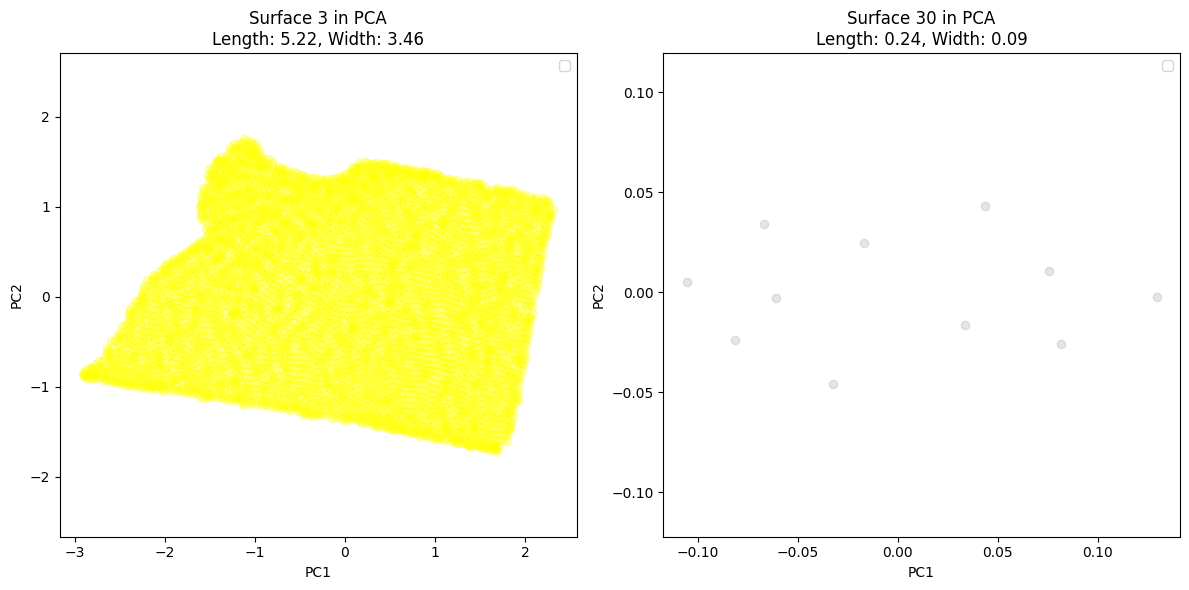

In [53]:
colors = [
    'red', 'green', 'blue', 'yellow', 
    'aliceblue', 'magenta', 'cyan', 'orange', 
    'lime', 'deeppink', 'darkgray', 'yellowgreen', 
    'sienna', 'indigo', 'teal', 'purple', 
    'salmon', 'navy', 'darkgoldenrod', 'black'
]

import random

def random_surface_indices():
    return list(random.sample(range(0, len(merged)), 4))

# surface_indices = random_surface_indices()
surface_indices = [3, 30]  # 4 surface muốn hiển thị
# colors = ['blue', 'green', 'orange', 'purple']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.flatten()

for idx, s_index in enumerate(surface_indices):
    surface_p_id = []
    for j, c in enumerate(merged):
        if j == s_index:
            for f_id in c:
                p_id = smoothed_mesh.get_cell(f_id).point_ids
                surface_p_id.extend(p_id)

    surface_p_id = list(set(surface_p_id))  # loại bỏ trùng lặp

    if len(surface_p_id) == 0:
        print(f"⚠️ Surface {s_index} has no points — skipped.")
        continue

    # PCA
    points = smoothed_mesh.points[surface_p_id]
    pca = PCA(n_components=2)
    transformed = pca.fit_transform(points)

    pca_length = transformed[:, 0].max() - transformed[:, 0].min()
    pca_width = transformed[:, 1].max() - transformed[:, 1].min()

    ax = axs[idx]
    ax.scatter(transformed[:, 0], transformed[:, 1], alpha=0.3,
               color=colors[s_index % len(colors)])
    # ax.axvline(0, color='red', label='PC1')
    # ax.axhline(0, color='blue', label='PC2')
    ax.set_title(f'Surface {s_index} in PCA\nLength: {pca_length:.2f}, Width: {pca_width:.2f}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.axis('equal')
    ax.legend()

plt.tight_layout()
plt.show()


## Long and Thin Faces Removing

In [38]:
def merge_long_thin_faces(clusters, face_normals, face_adjacency, real_clusters, noise_clusters):
    """
    Merge small (noise) face clusters into neighboring real clusters based on normal similarity,
    while avoiding merging adjacent noise clusters together.

    Parameters:
        clusters (List[Set[int]]): List of face index sets (each cluster).
        face_normals (np.ndarray): (M, 3) array of face normals.
        face_adjacency (dict[int, set[int]]): Adjacency list of faces.

    Returns:
        List[Set[int]]: Updated clusters with noise faces merged into real face clusters.
    """

    # Compute average normal of a cluster
    def cluster_avg_normal(cluster):
        normals = [face_normals[fi] for fi in cluster]
        summed = np.sum(normals, axis=0)
        norm = np.linalg.norm(summed)
        return summed / norm if norm > 0 else summed

    real_normals = [cluster_avg_normal(c) for c in real_clusters]
    noise_normals = [cluster_avg_normal(c) for c in noise_clusters]

    # Map each face to its real cluster (for fast lookup)
    face_to_real_cluster = {}
    for idx, cluster in enumerate(real_clusters):
        for f in cluster:
            face_to_real_cluster[f] = idx

    merged_indices = set()  # to skip already-merged noise clusters

    for ni, noise in enumerate(noise_clusters):
        if ni in merged_indices:
            continue
        noise_normal = noise_normals[ni]

        # Find neighboring real clusters
        neighbor_real_candidates = set()
        for fi in noise:
            for fj in face_adjacency.get(fi, []):
                if fj in face_to_real_cluster:
                    neighbor_real_candidates.add(face_to_real_cluster[fj])

        # Find best-matching real cluster
        best_real_idx = None
        best_angle = float('inf')

        for r_idx in neighbor_real_candidates:
            angle = normal_vector_angle(noise_normal, real_normals[r_idx])
            if angle < best_angle:
                best_real_idx = r_idx
                best_angle = angle

        # Merge noise into the best real cluster
        if best_real_idx is not None:
            real_clusters[best_real_idx].update(noise)
            merged_indices.add(ni)

    return real_clusters

In [39]:
merged2 = merge_long_thin_faces(merged, f_normals, f_adj, real_clusters, noise_clusters)

## Edge Extraction

In [40]:
def find_cluster_edge_faces(clusters, face_adjacency):
    """
    Identify edge faces in each cluster based on face adjacency.
    A face is considered an edge face if it has any neighbor outside its cluster.

    Args:
        clusters (List[Set[int]]): List of face clusters (each a set of face indices).
        face_adjacency (Dict[int, Set[int]]): Face adjacency map.

    Returns:
        List[Set[int]]: List of sets, each containing edge face indices per cluster.
    """
    cluster_edge_faces = []

    for cluster in clusters:
        edge_faces = set()

        for face in cluster:
            neighbors = face_adjacency.get(face, set())
            if any(n not in cluster for n in neighbors):
                edge_faces.add(face)

        cluster_edge_faces.append(edge_faces)

    return cluster_edge_faces

In [41]:
edge_faces_per_cluster = find_cluster_edge_faces(merged2, f_adj)
all_edge_faces = set().union(*edge_faces_per_cluster)

colors = [
    'red', 'green', 'blue', 'yellow', 
    'aliceblue', 'magenta', 'cyan', 'orange', 
    'lime', 'deeppink', 'darkgray', 'yellowgreen', 
    'sienna', 'indigo', 'teal', 'purple', 
    'salmon', 'navy', 'darkgoldenrod', 'black'
]

plotter = pv.Plotter(shape=(1, 2))

# # ========== Subplot 0: Original ==========
# plotter.subplot(0, 0)
# # plotter.add_title("Original")
# plotter.add_mesh(mesh, show_edges=True, color='aliceblue')

# ========== Subplot 1: Clusters ==========
plotter.subplot(0, 0)
# plotter.add_title("Clusters")
plotter.add_mesh(smoothed_mesh, show_edges=True)
for j, cluster in enumerate(clusters):
    face_indices = list(cluster)
    point_indices = np.unique(faces_nD[face_indices].flatten())
    color = colors[j % len(colors)]
    plotter.add_mesh(
        smoothed_mesh.extract_points(point_indices, adjacent_cells=False),
        color=color,
        point_size=10,
        render_points_as_spheres=True
    )

## ========== Subplot 2: Merge noise faces ==========
plotter.subplot(0, 1)
plotter.add_text("Noise faces removing", font_size=15)
plotter.add_mesh(smoothed_mesh, show_edges=True)
for j, cluster in enumerate(merged):
    face_indices = list(cluster)
    point_indices = np.unique(faces_nD[face_indices].flatten())
    color = colors[j % len(colors)]
    plotter.add_mesh(
        smoothed_mesh.extract_points(point_indices, adjacent_cells=False),
        color=color,
        point_size=10,
        render_points_as_spheres=True
    )

## ========== Subplot 3: Merge long and thin faces ==========
# plotter.subplot(0, 1)
# plotter.add_text("Long and thin faces merging", font_size=15)
# plotter.add_mesh(smoothed_mesh, show_edges=True)
# for j, cluster in enumerate(merged2):
#     face_indices = list(cluster)
#     point_indices = np.unique(faces_nD[face_indices].flatten())
#     color = colors[j % len(colors)]
#     plotter.add_mesh(
#         smoothed_mesh.extract_points(point_indices, adjacent_cells=False),
#         color=color,
#         point_size=10,
#         render_points_as_spheres=True
#     )

# ## ========== Subplot 4: Edges ==========
# plotter.subplot(0, 2)
# # plotter.add_text("Edges", font_size=12)
# # plotter.add_mesh(smoothed_mesh, opacity=0.1, show_edges=True)

# # Extract edge faces as cells
# edge_face_mask = np.zeros(smoothed_mesh.n_cells, dtype=bool)
# edge_face_mask[list(all_edge_faces)] = True
# edge_part = smoothed_mesh.extract_cells(edge_face_mask)
# plotter.add_mesh(edge_part, color='orange', show_edges=True)

# Hiển thị
plotter.link_views()
plotter.show(window_size=(3000, 1000))

# del cluster, face_indices, edge_face_mask, plotter
gc.collect()


Widget(value='<iframe src="http://localhost:37471/index.html?ui=P_0x7fd3e27c2050_4&reconnect=auto" class="pyvi…

0

In [42]:
time_end = time.time()

print(f"Running times (s): {time_end - time_start}")

Running times (s): 44.912354946136475


In [43]:
import pyvista as pv
import numpy as np

# Chọn cell chính
target_cell_id = flat_f_sorted[-1][0]

# Lấy cell lân cận
cell_neighbors = smoothed_mesh.cell_neighbors(target_cell_id)

# Tô màu các cell
n_cells = smoothed_mesh.n_cells
cell_colors = np.full((n_cells, 3), fill_value=[200, 200, 200], dtype=np.uint8)
cell_colors[target_cell_id] = [255, 165, 0]
for neighbor_id in cell_neighbors:
    cell_colors[neighbor_id] = [0, 255, 0]

# ✅ Tạo danh sách cell cần hiển thị normal
rendered_cell_ids = [target_cell_id] + cell_neighbors

# ✅ Trích xuất lưới con chứa các cell cần hiển thị normal
highlighted_cells = smoothed_mesh.extract_cells(rendered_cell_ids)

# ✅ Tính normal vector và centroid
arrow_list = []
for i in range(highlighted_cells.n_cells):
    cell = highlighted_cells.extract_cells(i)
    points = cell.points

    # Tính centroid
    centroid = points.mean(axis=0)

    # Tính normal
    v1 = points[1] - points[0]
    v2 = points[2] - points[0]
    normal = np.cross(v1, v2)
    normal /= np.linalg.norm(normal)
    normal = np.abs(normal)

    arrow = pv.Arrow(start=centroid, direction=normal, scale=0.05)
    arrow_list.append(arrow)

# Gộp các mũi tên lại
all_arrows = arrow_list[0]
for arrow in arrow_list[1:]:
    all_arrows += arrow

# ✅ Hiển thị bằng plotter
plotter = pv.Plotter()
plotter.add_mesh(smoothed_mesh, scalars=cell_colors, rgb=True, show_edges=True, opacity=1)
plotter.add_mesh(all_arrows, color="blue")  # hiển thị normal vector
plotter.show()


Widget(value='<iframe src="http://localhost:37471/index.html?ui=P_0x7fd3e274e7d0_5&reconnect=auto" class="pyvi…

In [44]:


# Cell chính
target_cell_id = flat_f_sorted[0][0]

# Lấy cell lân cận
cell_neighbors = smoothed_mesh.cell_neighbors(target_cell_id)
rendered_cell_ids = [target_cell_id] + cell_neighbors

# Trích xuất lưới con chỉ gồm các cell cần hiển thị
highlighted_cells = smoothed_mesh.extract_cells(rendered_cell_ids)

# Tạo màu tương ứng cho từng cell được hiển thị
cell_colors = []

for cid in rendered_cell_ids:
    if cid == 14096:
        cell_colors.append([255, 165, 0])  # cam
    else:
        cell_colors.append([0, 255, 0])    # xanh lá

cell_colors = np.array(cell_colors, dtype=np.uint8)

# Tính và tạo mũi tên pháp tuyến (normal vector)
arrow_list = []
for i in range(highlighted_cells.n_cells):
    cell = highlighted_cells.extract_cells(i)
    points = cell.points

    # Tính centroid
    centroid = points.mean(axis=0)

    # Tính normal
    v1 = points[1] - points[0]
    v2 = points[2] - points[0]
    normal = np.cross(v1, v2)
    normal /= np.linalg.norm(normal)
    normal = np.abs(normal)

    arrow = pv.Arrow(start=centroid, direction=normal, scale=0.015)
    arrow_list.append(arrow)

# Gộp mũi tên
all_arrows = arrow_list[0]
for arrow in arrow_list[1:]:
    all_arrows += arrow

# Hiển thị
plotter = pv.Plotter()
plotter.add_mesh(highlighted_cells, scalars=cell_colors, rgb=True, show_edges=True)
plotter.add_mesh(all_arrows, color="blue")
plotter.show(window_size=(800, 500))

Widget(value='<iframe src="http://localhost:37471/index.html?ui=P_0x7fd38815fb50_6&reconnect=auto" class="pyvi…

In [45]:
rendered_cell_ids

[14098,
 14096,
 21202,
 14099,
 64020,
 14101,
 64022,
 64023,
 21205,
 64025,
 21204,
 21203,
 14100]